In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from os import path
import os

In [20]:
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Параметры изображений и загрузки
img_size = 224
batch_size = 32

# Пути к данным
train_dir = path.join('/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/samples/images/train')
val_dir = path.join("/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/samples/images/validation")
test_dir = path.join("/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/samples/images/test")

# Генераторы изображений
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Количество классов (фрукты, овощи и т.д.)
num_classes = train_gen.num_classes


Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Заморозим базовые слои
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [23]:
history_frozen = model.fit(train_gen,
                           validation_data=val_gen,
                           epochs=5)


/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 7/98 ━━━━━━━━━━━━━━━━━━━━ 55s 611ms/step - accuracy: 0.0357 - loss: 3.8285

/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/.venv/lib/python3.11/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 717ms/step - accuracy: 0.0401 - loss: 3.6483 - val_accuracy: 0.0570 - val_loss: 3.4781
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 660ms/step - accuracy: 0.0555 - loss: 3.4763 - val_accuracy: 0.0855 - val_loss: 3.3461
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 64s 655ms/step - accuracy: 0.0733 - loss: 3.3931 - val_accuracy: 0.0940 - val_loss: 3.3045
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 64s 651ms/step - accuracy: 0.0830 - loss: 3.3763 - val_accuracy: 0.1197 - val_loss: 3.2819
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 657ms/step - accuracy: 0.1071 - loss: 3.3335 - val_accuracy: 0.0940 - val_loss: 3.2393


In [24]:
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # сниженный lr
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_full = model.fit(train_gen,
                         validation_data=val_gen,
                         epochs=5)


Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.0561 - loss: 6.2881 - val_accuracy: 0.0484 - val_loss: 4.1658
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.2034 - loss: 3.2701 - val_accuracy: 0.0256 - val_loss: 4.6680
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.4330 - loss: 2.0665 - val_accuracy: 0.0171 - val_loss: 4.3204
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.6447 - loss: 1.3774 - val_accuracy: 0.0570 - val_loss: 4.0941
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.7853 - loss: 0.9644 - val_accuracy: 0.1083 - val_loss: 3.5022


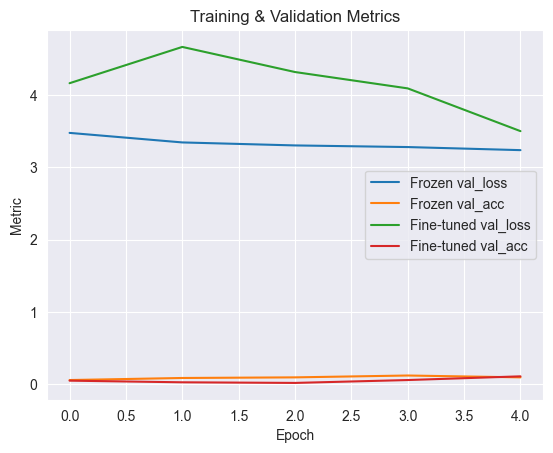

In [25]:
def plot_history(histories, labels):
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} val_loss')
        plt.plot(history.history['val_accuracy'], label=f'{label} val_acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Training & Validation Metrics')
    plt.grid(True)
    plt.show()

plot_history([history_frozen, history_full], ['Frozen', 'Fine-tuned'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


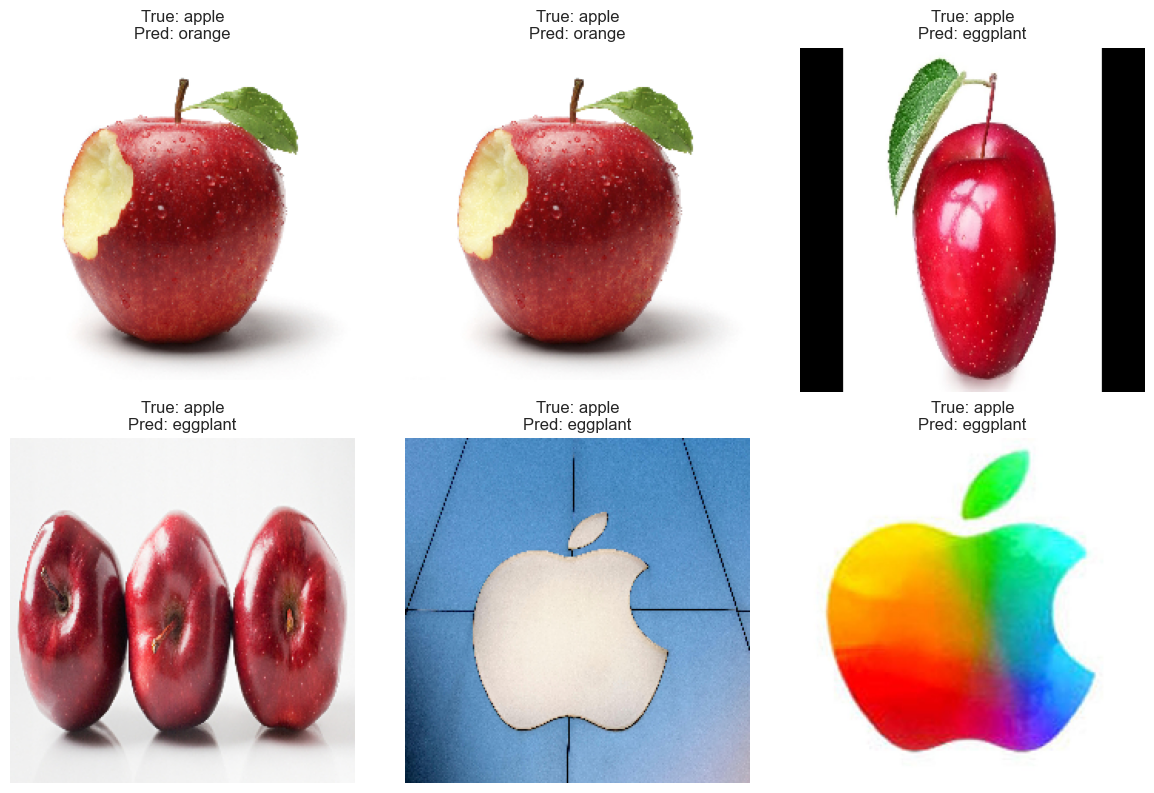

In [26]:
class_names = list(train_gen.class_indices.keys())
images, labels = next(val_gen)
preds = model.predict(images)

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    pred_label = class_names[np.argmax(preds[i])]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
!pip install torch
!pip install torchvision

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0b/fa/f33a4148c6fb46ca2a3f8de39c24d473822d5774d652b66ed9b1214da5f7/torch-2.6.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/4d/36/2a115987e2d8c300a974597416d9de88f2444426de9571f4b59b2cca3acc/filelock-3.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/44/4b/e0cfc1a6f17e990f3e64b7d941ddc4acdc7b19d6edd51abf495f32b1a9e4/fsspec-2025.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b

In [28]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report


In [31]:
data_dir = '/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/samples/images'  # должна содержать /train и /val
batch_size = 32
img_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'validation']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'))
    for x in ['train', 'validation']
}

class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [32]:
model = models.resnet50(pretrained=True)

# Заморозим все слои
for param in model.parameters():
    param.requires_grad = False

# Заменим классификатор
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # адаптируем под число классов

model = model.to(device)


/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/kuki/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 14.3MB/s]


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

def train_model(model, num_epochs=5):
    history = {'train_loss': [], 'validation_loss': [], 'train_acc': [], 'validation_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'validation']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return history

history = train_model(model, num_epochs=5)


Epoch 1/5


/Users/kuki/PycharmProjects/machine-learning-TrippyBubble/.venv/lib/python3.11/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.9730 Acc: 0.5223
Validation Loss: 0.6970 Acc: 0.8291
Epoch 2/5
Train Loss: 0.8257 Acc: 0.7814
Validation Loss: 0.4007 Acc: 0.8889
Epoch 3/5
Train Loss: 0.6203 Acc: 0.8283
Validation Loss: 0.3236 Acc: 0.9117
Epoch 4/5
Train Loss: 0.5307 Acc: 0.8514
Validation Loss: 0.3250 Acc: 0.8974
Epoch 5/5
Train Loss: 0.4521 Acc: 0.8639
Validation Loss: 0.2660 Acc: 0.9145


In [35]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
history2 = train_model(model, num_epochs=3)


Epoch 1/3
Train Loss: 0.4029 Acc: 0.8665
Validation Loss: 0.1686 Acc: 0.9544
Epoch 2/3
Train Loss: 0.1592 Acc: 0.9502
Validation Loss: 0.1157 Acc: 0.9658
Epoch 3/3
Train Loss: 0.1164 Acc: 0.9624
Validation Loss: 0.1122 Acc: 0.9658


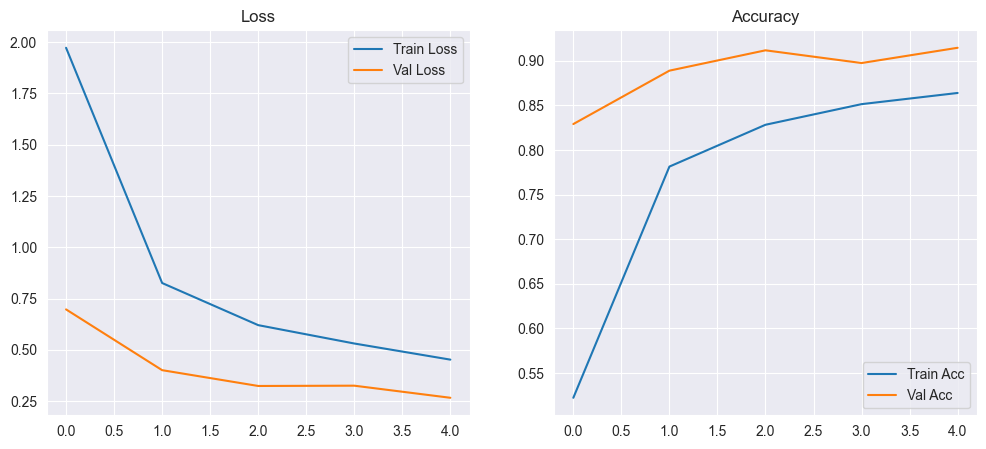

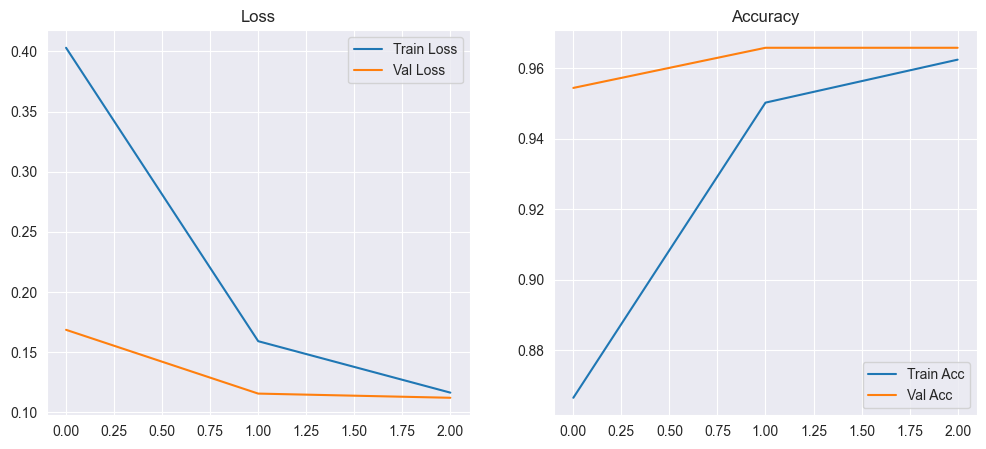

In [36]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['validation_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['validation_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)
plot_history(history2)


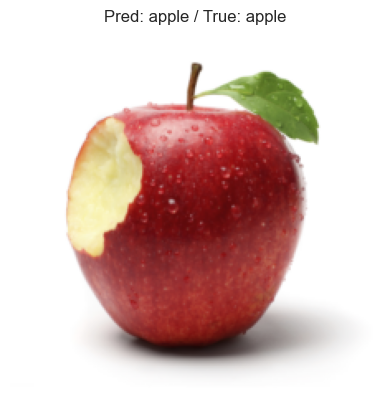

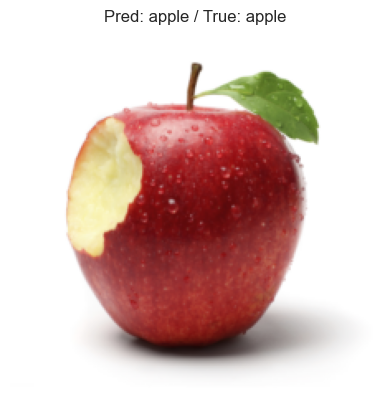

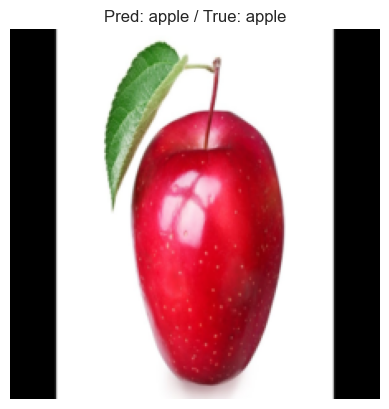

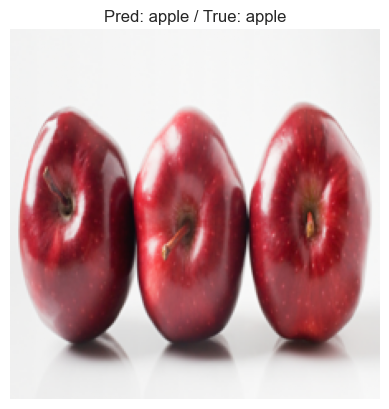

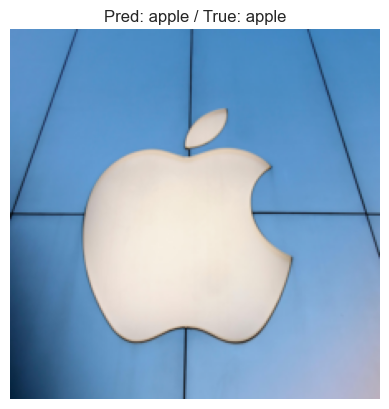

In [37]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

model.eval()
inputs, classes = next(iter(dataloaders['validation']))
inputs = inputs[:5].to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

for i in range(len(inputs)):
    imshow(inputs[i].cpu(), title=f'Pred: {class_names[preds[i]]} / True: {class_names[classes[i]]}')
    plt.show()
